In [1]:
%matplotlib inline 
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from skimage.feature import hog
from skimage import exposure

In [2]:
def load_and_shuffle_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read images in grayscale
                if img is not None:
                    images.append(img)
                    labels.append(label)

    # Shuffle images and labels in the same order
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images[:], labels[:] = zip(*combined)

    return images, labels

def remove_unknown_and_empty(images, labels):
    cleaned_images = []
    cleaned_labels = []

    for img, label in zip(images, labels):
        # Check if the image is not None and label is not empty
        if img is not None and label:
            cleaned_images.append(img)
            cleaned_labels.append(label)

    return cleaned_images, cleaned_labels

# Assuming your dataset is organized like this:
# dataset_folder/
# ├── train/
# │   ├── happy/
# │   ├── sad/
# │   └── ...
# └── test/
#     ├── happy/
#     ├── sad/
#     └── ...

# Read the Paths
train_folder = 'C:\\Users\\Moamn Mahmoud\\Downloads\\data\\train'
test_folder = 'C:\\Users\\Moamn Mahmoud\\Downloads\\data\\test'

# Load and shuffle training images and labels
X_train, y_train = load_and_shuffle_images_from_folder(train_folder)

# Load and shuffle testing images and labels
X_test, y_test = load_and_shuffle_images_from_folder(test_folder)

# Remove unknown images and empty labels
X_train, y_train = remove_unknown_and_empty(X_train, y_train)
X_test, y_test = remove_unknown_and_empty(X_test, y_test)


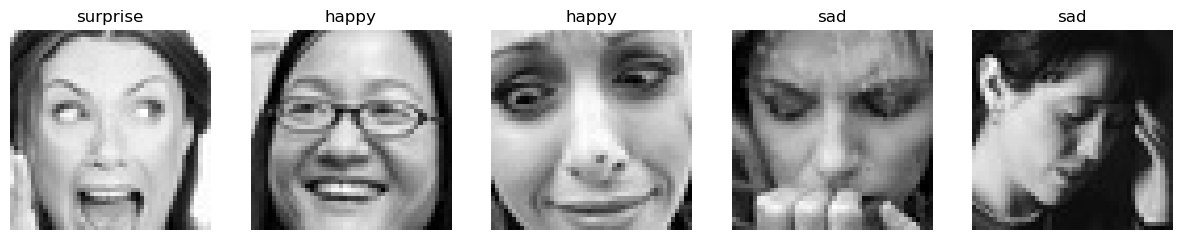

In [3]:
# Display the first five images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')  # Assuming images are grayscale
    ax.set_title(y_train[i])
    ax.axis('off')

plt.show()

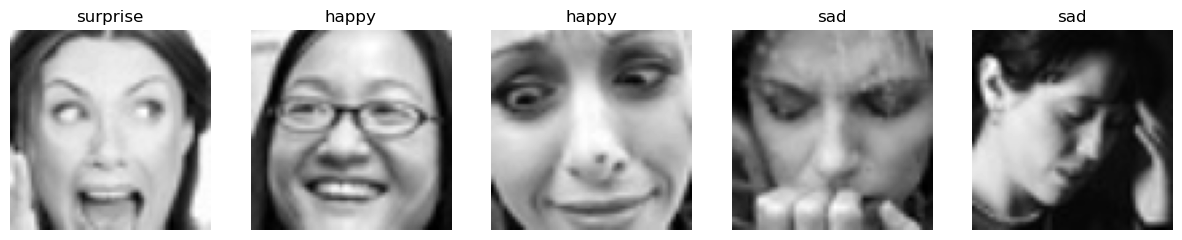

In [4]:
def preprocess_images(images):
    preprocessed_images = []

    # Reduce image size to (75, 75)
    target_size = (75, 75)

    for img in images:
        # Resize image to a consistent size (e.g., 75 x 75)
        resized_img = cv2.resize(img, target_size)

        # Check if the image is already in grayscale
        if len(resized_img.shape) == 2:
            # Image is already grayscale, no normalization
            preprocessed_img = resized_img.astype('float32')
        else:
            # Convert the image to grayscale
            grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

            # No normalization for grayscale images
            preprocessed_img = grayscale_img.astype('float32')

        preprocessed_images.append(preprocessed_img)

    return preprocessed_images

# Preprocess training and testing images
X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

# Display the first five images after preprocessing
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')  # Assuming images are grayscale
    ax.set_title(y_train[i])
    ax.axis('off')

plt.show()

In [5]:
def extract_hog_features(images):
    hog_features = []

    for img in images:
        # Compute HOG features
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

        hog_features.append(fd)

    return hog_features

# Extract HOG features for training data
train_hog_features = extract_hog_features(X_train)

# Extract HOG features for testing data
test_hog_features = extract_hog_features(X_test)

# Convert HOG features to NumPy arrays
X_train_features = np.array(train_hog_features)
X_test_features = np.array(test_hog_features)


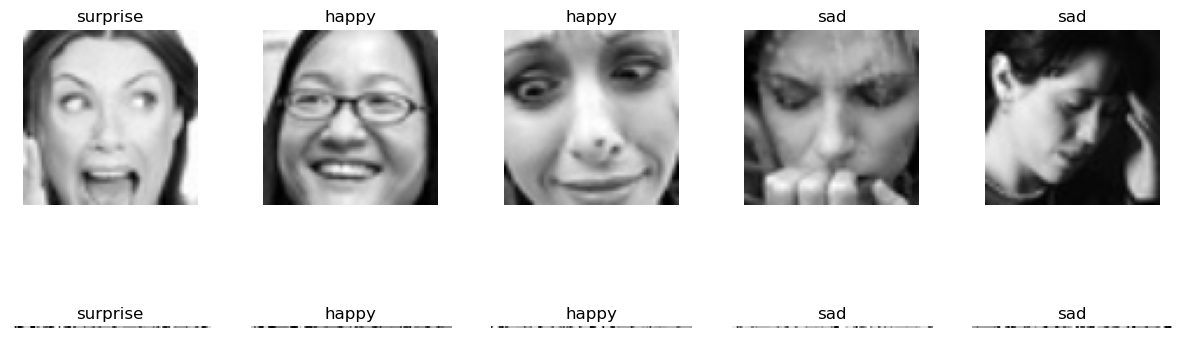

In [6]:
def visualize_images(images, features, labels, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title(labels[i])
        axes[0, i].axis('off')

        # HOG Image
        axes[1, i].imshow(features[i].reshape(1, -1), cmap='gray')
        axes[1, i].set_title(labels[i])
        axes[1, i].axis('off')

    plt.show(block=False)
    plt.pause(0.1)  # Adjust the pause time if necessary

# Visualize the original and HOG images for the first five samples
visualize_images(X_train, X_train_features, y_train, num_images=5)

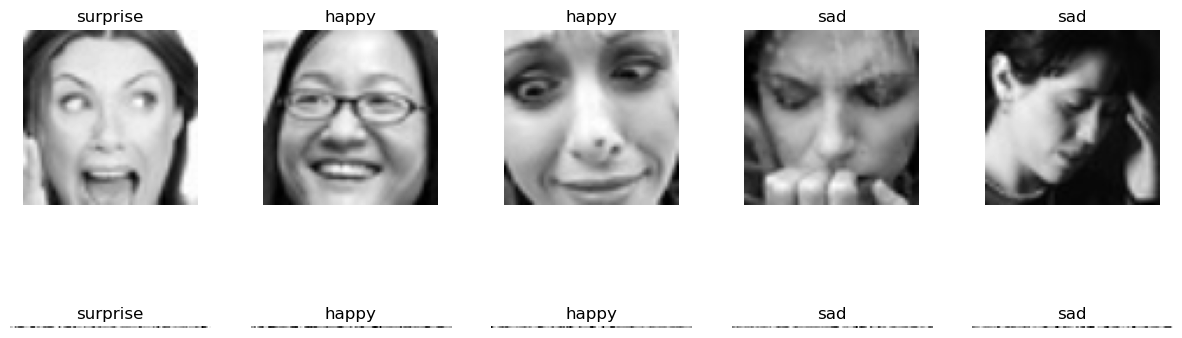

In [7]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Visualize the original and scaled HOG images for the first five samples
visualize_images(X_train, X_train_scaled, y_train, num_images=5)

In [8]:
# Map labels to numerical values
label_mapping = {label: i for i, label in enumerate(np.unique(y_train))}
y_train_encoded = np.array([label_mapping[label] for label in y_train])
y_test_encoded = np.array([label_mapping[label] for label in y_test])

print("Encoded Labels for the First 10 Training Samples:")
print(y_train_encoded[:5])

print("\nEncoded Labels for the First 10 Testing Samples:")
print(y_test_encoded[:5])

Encoded Labels for the First 10 Training Samples:
[4 1 1 3 3]

Encoded Labels for the First 10 Testing Samples:
[4 3 0 2 0]


In [9]:
# Train Logistic Regression model with verbose=True
model = LogisticRegression(verbose=1, n_jobs=-1, solver='sag')
model.fit(X_train_scaled, y_train_encoded)

# Score on the training set
#train_score = model.score(X_train_scaled, y_train_encoded)
#print("Training Set Score:", train_score)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Tccuracy:", accuracy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 8 seconds
Tccuracy: 0.44332285288763856


D:\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished


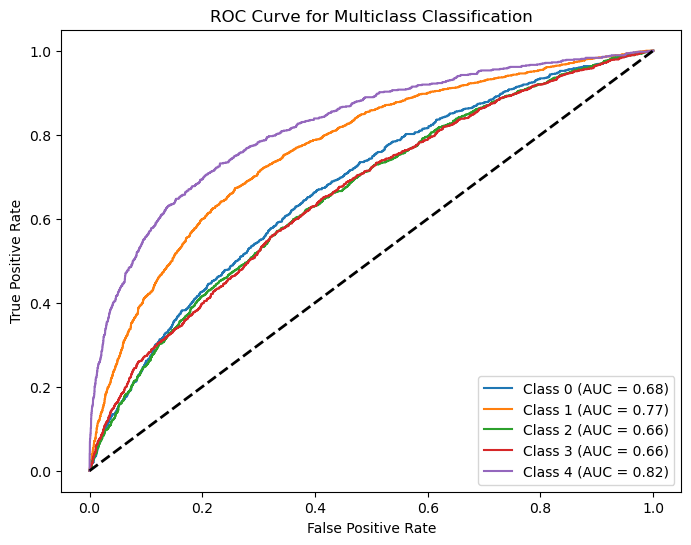

In [10]:
# Binarize the labels for multiclass ROC curve
y_train_bin = label_binarize(y_train_encoded, classes=np.unique(y_train_encoded))
y_test_bin = label_binarize(y_test_encoded, classes=np.unique(y_test_encoded))

# Fit OneVsRestClassifier for multiclass classification
model = OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=100))
model.fit(X_train_scaled, y_train_bin)

# Predict probabilities on the test set
y_score = model.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_train_encoded))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(np.unique(y_train_encoded))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()


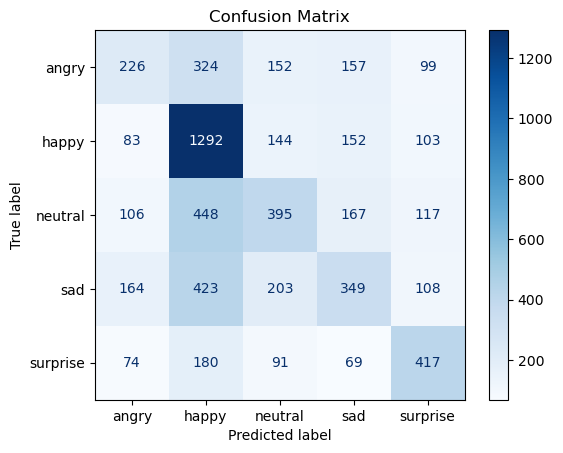

In [11]:
# Confusion Matrix
# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()